In [ ]:
!conda install -c intel scikit-learn

# Training a sentiment analysis classifier based on supervised machine learning algorithms

In [1]:
import string

import pandas as pd

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import ConfusionMatrixDisplay, precision_score, recall_score, f1_score

In [2]:
pd.set_option('display.max_colwidth', None)

In [3]:
stop_words = set(stopwords.words('spanish'))

In [4]:
def tokenizer(text):
    tt = TweetTokenizer()
    return tt.tokenize(text)

### Loading labeled tweets

In [5]:
# Dataset loaded from: https://docs.google.com/spreadsheets/d/11_E2ngsEOyTQwbwVVRHY5urzFF95BQCV/edit#gid=1788161364
tweets_df = pd.read_csv('./data/tweets_escenario1.2.csv', sep = ',')

In [6]:
tweets_df.shape

(627, 3)

In [7]:
tweets_df.head()

,full_text,sentiment,emotion
0,"@IvanDuque Sus socios de las AGC tienen este platanal vuelto mierda, pero no haces nada, usted inservible, ha logrado la peor inflación en Colombia y solo pública maricadas sin sentido, se robó las elecciones para entregar el país, valiente idiota tenemos de presidente.",negative,anger
1,@AlvaroUribeVel Ellos también celebran por que Maduro PetroGustavo Ivan Cepeda Timo Teodora Bobolivar entre muchos más sufren de insomnio.\nUribe Velez Alvarito no los deja dormir\nEl enemigo para las elecciones no es Fico.... Sino el Excelentísimo y más Grande Presidente que ha tenido Colombia,negative,anger
2,"@PDleh @cokycafe @PGN_COL En Colombia existen miles de leyes para controlar los funcionarios públicos pero a la hora de aplicarlas ""se les olvida que existen"". ¿Que más pruebas quieren? ¿Porque avalan unas elecciones, las del 13 de marzo, donde pado de todo lo que no debía de pasar? Escuchamos respuestas",negative,anger
3,Petro ahora es el Capitán América o mejor dicho el Capitán Colombia de ganar las elecciones. No soltara el escudo ni para dormir 😂 https://t.co/k56Dv7id1J,negative,joy
4,"#OtraPregunta \n""Petro promete reanudar relaciones diplomáticas con Maduro si gana elecciones en Colombia""...\nEsto no pinta nada bien... y si además gana Lula en Brasil...\n¿Esto como que va para largo? https://t.co/wpQsl5KoRe",negative,fear


In [8]:
tweets_df.sample(n=200, random_state=2)

,full_text,sentiment,emotion
435,Se iniciaron los simulacros de las elecciones de presidente 2022 https://t.co/07SWb8GAT1 / @Registraduria,neutral,joy
562,"Insisto...el peor enemigo de la llamada #Derecha en #Colombia es la misma ""Derecha""...\nLlegar DIVIDIDOS a las elecciones PRESIDENCIALES, No me parece la mejor táctica, para enfrentar al #PapilomaHumano \nSegún la posición de los Astros, podría ser Desastroso para el #29Mayo https://t.co/jv4cmhH9mv",negative,sadness
368,"@tinagus2000 Evidentemente la persecución judicial, la aceleración de cosas, las trabas del @cnegobec para la inscripción , el viaje de la fiscal a Colombia y el papel de otras instituciones influyeron en la victoria de Lasso. Al otro candidato lo desgastaron, mucha antes de las elecciones.",neutral,sadness
342,“Casi 3000 aspirantes a jurados de votación inhabilitados en Colombia” https://t.co/2MCo0SBpog #Elecciones ✍️ por @gabrielamor,neutral,anger
80,@CGurisattiNTN24 El senador de Colombia en EEUUtiene toda la razón sino tienen gente preparada para las elecciones nos van a robar la libertad en primera vuelta,negative,fear
...,...,...,...
556,#NarcotraFICO se tomó a Colombia para impedir las elecciones 2022/2026\n\nhttps://t.co/oa14iGRkwJ https://t.co/1bUQEGwhWh,negative,anger
623,"@lafm tremendo informe de la posible corrupción en el fraude del pasado 13 de marzo a la Colombia humana le asignaron 24 mil jurados que si votaron 2 veces cada uno significaría el robo más grande en Colombia, y el registrador intento quitar la huella y la firma de las elecciones",positive,joy
23,El candidato a la Presidencia de Colombia Gustavo Petro promete restablecer las relaciones con Venezuela si gana las elecciones y llega a la Presidencia.\n\nhttps://t.co/XM8QX8IaLk,neutral,joy
12,"A caso en Colombia hay Procuraduría? O si existe está sin cabeza? Las elecciones al Congreso fueron un fraude, hay que anularlas y repetirlas; hay que cerrar el CNE y sacar a todos en la Registraduría, la mayoría para una CARCEL https://t.co/wSfZAJfJcX",negative,anger


In [9]:
df2 = tweets_df.sample(n=200).copy()
len(df2)

200

In [10]:
#df2.to_csv('Dataset.csv')

In [11]:
df2['sentiment'].value_counts(dropna = False, normalize = True)

negative    0.670
neutral     0.275
positive    0.055
Name: sentiment, dtype: float64

In [12]:
df2['emotion'].value_counts(dropna = False, normalize = True)

anger      0.36
fear       0.25
joy        0.22
sadness    0.17
Name: emotion, dtype: float64

### Leaving out unlabeled texts, this data is not useful for training or validating a supervised model

In [13]:
# Removing  unlabeled tweets
tweets_labeled_df = df2.loc[df2['sentiment'].notnull()]

In [14]:
tweets_labeled_df.shape

(200, 3)

In [15]:
tweets_unlabeled_df = df2.loc[df2['sentiment'].isnull()]

In [16]:
tweets_unlabeled_df.shape

(0, 3)

In [17]:
# Scenario 1: Working with all classes

# Scenario 2: Working only with positive and negative classes
# Removing neutral class
#tweets_labeled_df = tweets_labeled_df.loc[tweets_labeled_df['sentiment'].isin(['positive', 'negative'])]

# Scenario 3: Treating neutral as positive classes
tweets_labeled_df['sentiment'] = tweets_labeled_df['sentiment'].replace({'neutral': 'positive'})

### Splitting train and test datasets

In [18]:
X_train, X_test, y_train, y_test = train_test_split(tweets_labeled_df['full_text'], tweets_labeled_df['sentiment'], test_size = 0.2, stratify = tweets_labeled_df['sentiment'], random_state = 1)


In [19]:
X_train.shape

(160,)

In [20]:
pd.Series(y_train).value_counts(normalize = True)

negative    0.66875
positive    0.33125
Name: sentiment, dtype: float64

In [21]:
X_test.shape

(40,)

In [22]:
pd.Series(y_test).value_counts(normalize = True)

negative    0.675
positive    0.325
Name: sentiment, dtype: float64

### Vectorizing texts

<table>
    <tbody>
        <tr>
            <td>
                <h4>Bag of Words</h4>
                <img src="./imgs/bow.png" style="width: 500px;">
            </td>
            <td>
                <h4>TF-IDF</h4>
                <img src="./imgs/tf-idf.png" style="width: 500px;">
            </td>
        </tr>
    </tbody>
</table>

In [23]:
bow = CountVectorizer(tokenizer = tokenizer, stop_words = stop_words)

In [24]:
tfidf = TfidfVectorizer(tokenizer = tokenizer, stop_words = stop_words)

In [25]:
X_bow = bow.fit_transform(X_train)

In [26]:
X_tfidf = tfidf.fit_transform(X_train)

### Training and evaluating a model using BOW

In [27]:
model = RandomForestClassifier()

In [28]:
model.fit(X_bow, y_train)

RandomForestClassifier()

In [29]:
y_train_bow_predict = model.predict(X_bow)
y_test_bow_predict = model.predict(bow.transform(X_test))

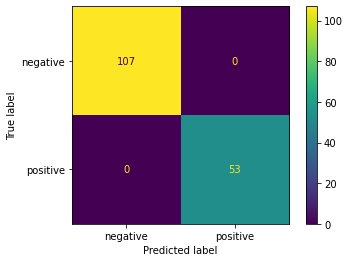

In [30]:
ConfusionMatrixDisplay.from_predictions(y_train, y_train_bow_predict)

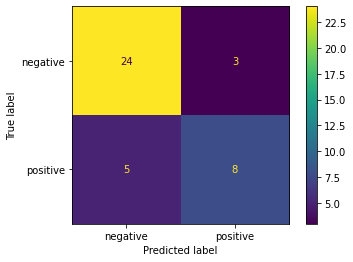

In [31]:
ConfusionMatrixDisplay.from_predictions(y_test, y_test_bow_predict)

In [32]:
# Metrics calculation for binary classes
print('Precision:', precision_score(y_test, y_test_bow_predict, pos_label = 'positive'))
print('Recall:', recall_score(y_test, y_test_bow_predict, pos_label = 'positive'))
print('F1:', f1_score(y_test, y_test_bow_predict, pos_label = 'positive'))
print('Precision:', precision_score(y_test, y_test_bow_predict, pos_label = 'negative'))
print('Recall:', recall_score(y_test, y_test_bow_predict, pos_label = 'negative'))
print('F1:', f1_score(y_test, y_test_bow_predict, pos_label = 'negative'))

Precision: 0.7272727272727273
Recall: 0.6153846153846154
F1: 0.6666666666666667
Precision: 0.8275862068965517
Recall: 0.8888888888888888
F1: 0.8571428571428572


In [33]:
# Metrics calculation for more than two classes
#print('Precision:', precision_score(y_test, y_test_bow_predict, average = None))
#print('Recall:', recall_score(y_test, y_test_bow_predict, average = None))
#print('F1:', f1_score(y_test, y_test_bow_predict, average = None))

### Training and evaluating a model using TF-IDF

In [34]:
model = RandomForestClassifier()

In [35]:
model.fit(X_tfidf, y_train)

RandomForestClassifier()

In [36]:
y_train_tfidf_predict = model.predict(X_tfidf)
y_test_tfidf_predict = model.predict(bow.transform(X_test))

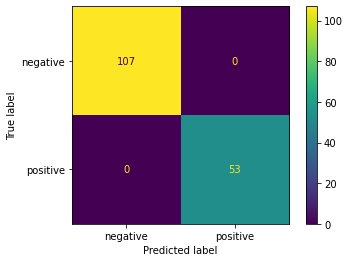

In [37]:
ConfusionMatrixDisplay.from_predictions(y_train, y_train_tfidf_predict)

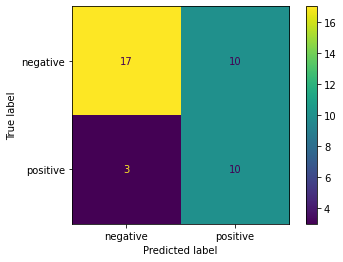

In [38]:
ConfusionMatrixDisplay.from_predictions(y_test, y_test_tfidf_predict)

In [39]:
# Metrics calculation for binary classes
print('Precision:', precision_score(y_test, y_test_tfidf_predict, pos_label = 'positive'))
print('Recall:', recall_score(y_test, y_test_tfidf_predict, pos_label = 'positive'))
print('F1:', f1_score(y_test, y_test_tfidf_predict, pos_label = 'positive'))
print('Precision:', precision_score(y_test, y_test_tfidf_predict, pos_label = 'negative'))
print('Recall:', recall_score(y_test, y_test_tfidf_predict, pos_label = 'negative'))
print('F1:', f1_score(y_test, y_test_tfidf_predict, pos_label = 'negative'))

Precision: 0.5
Recall: 0.7692307692307693
F1: 0.6060606060606061
Precision: 0.85
Recall: 0.6296296296296297
F1: 0.723404255319149


In [ ]:
# Metrics calculation for more than two classes
#print('Precision:', precision_score(y_test, y_test_tfidf_predict, average = None))
#print('Recall:', recall_score(y_test, y_test_tfidf_predict, average = None))
#print('F1:', f1_score(y_test, y_test_tfidf_predict, average = None))

### How interpret the results?

<table>
    <tbody>
        <tr>
            <td>
                <img src="./imgs/confusion-matrix.png" style="height: 400px;">
            </td>
            <td>
                <img src="./imgs/precision-recall.png" style="height: 600px;">
            </td>
        </tr>
    </tbody>
</table>

### Analyzing errors

In [ ]:
error_df = pd.concat(
    [ pd.concat([X_test, y_test ], axis = 1).reset_index(),
    pd.Series(y_test_bow_predict) ]
, axis = 1).rename(columns = { 'sentiment': 'actual', 0: 'predicted' })

error_df.drop('index', inplace = True, axis = 1)

In [ ]:
error_df.shape

In [ ]:
error_df.loc[error_df['actual'] != error_df['predicted']].head(100)